In [1]:
#!/usr/bin/env python3
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from keras.utils import plot_model
import IPython.display
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
#if i want to speed up and use one file
#i aggregate the data points for five files into aggregate.csv. i have removed the time predictor from the data set

#files2 = "CSVLog_20190518_122417.csv" this file is buggy

# cleaned, correct dataset
files = "./data/merged.csv"

raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
dataset = raw_dataset.copy()


#remove whitespace in front of column name
dataset.columns = dataset.columns.str.lstrip()
# Major bugs and suggestions:
# Baseline, take mean of the data points (MPG) to determine baseline
# Another thing to predict: rate of change of MPG, maybe how much we are accelerating
# When velocity decreases, how fast are we decreasing by? (acceleration)
# Split dataset properly
# Linear regression as our baseline
# Remove the features that don't really correlate with our MPG
# Generate test set using equation

In [3]:
def setMaxInstantFuelEco(dataset, maxNum):
    copy = dataset.copy()
    for i in range(len(dataset.index)):
        if dataset.iloc[i, len(dataset.columns) - 1] > maxNum:
            copy.iloc[i, len(dataset.columns) - 1] = maxNum
    return copy
maxNum = 45
maxedDataSet = setMaxInstantFuelEco(dataset, maxNum)
maxedDataSet.tail()

,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG)
4855,19.60784,11.76471,59.0,29.8254,33.72549,924.2921,185.0,560.25,74.5098,443.8155,0.994239,86.0,12.40264,-1.5625,0.129654,0.0,0.095216,0.0
4856,19.60784,11.37255,59.0,29.8254,33.72549,918.3861,185.0,560.00,74.5098,443.8155,0.994239,86.0,12.40264,-1.5625,0.244755,0.0,0.163490,0.0
4857,19.60784,11.37255,59.0,29.8254,33.33333,903.6210,185.0,611.00,74.5098,439.4644,0.994239,86.0,11.81204,-1.5625,0.264600,0.0,0.176746,0.0
4858,18.43137,12.94118,59.0,29.8254,40.78431,1328.8540,185.0,686.50,74.5098,617.8608,0.994239,86.0,13.58385,-1.5625,0.269892,0.0,0.180281,0.0
4859,24.31373,12.54902,59.0,29.8254,40.00000,1154.6270,185.0,712.25,74.5098,558.3953,0.994239,86.0,14.17445,-1.5625,0.367794,0.0,0.245677,0.0


In [4]:
%%time 
#set seed here!

# Bugs to fix: split evenly driving on the high way vs city (look at speed for this)
# Split evenly the data amongst the datasets

#creating data and splitting and random shuffling
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

np.random.seed(88)
train, validate, test = train_validate_test_split(maxedDataSet)

train_labels = train.pop("Instant fuel economy (MPG)")
validate_labels = validate.pop("Instant fuel economy (MPG)")
test_labels = test.pop("Instant fuel economy (MPG)")


CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 7.58 ms


In [ ]:
#test_labels
#train.dtypes

In [5]:
train = train.apply(lambda col:pd.to_numeric(col, errors='coerce'))
train_stats = train.describe(include = 'all')
#train_stats = train.transpose()
train_stats
# training stats is a pandas data frame type
# use these values to normalize


,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr)
count,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000
mean,33.595040,19.881788,70.418313,29.784386,42.043761,1766.745613,186.031756,1400.427555,75.629523,884.097529,0.979726,78.340398,17.439874,6.424683,1.361256,26.585141,0.922259
std,23.284341,12.295247,14.013235,0.789023,25.007748,1127.283586,9.506686,623.421905,10.916572,549.989156,0.045432,14.980400,8.393078,3.334409,1.529042,22.027432,1.033071
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.343750,0.000000,0.000000,0.000000
25%,17.254900,11.764710,62.600000,29.825400,23.529410,885.903000,183.200000,800.937500,67.450980,478.624500,0.990305,66.200000,11.221440,3.906250,0.297675,6.213712,0.201277
50%,24.313730,14.509800,64.400000,29.825400,38.823530,1169.392000,185.000000,1346.875000,77.647060,587.402800,0.993568,73.400000,14.765050,7.812500,0.654224,24.854850,0.440496
75%,44.705880,24.313730,73.400000,29.825400,51.764710,2290.059500,190.400000,1888.312500,81.470587,1167.554000,0.995520,82.400000,26.577090,8.593750,1.987146,38.525010,1.350859
max,99.215680,90.980390,118.400000,30.120700,100.000000,5906.020000,204.800000,4474.500000,93.333340,2937.014000,1.016260,122.000000,30.711300,12.500000,11.959920,75.807290,8.026347


In [6]:
# Even if we make our own, the values are similar but not exact. mine vs their mean and var
# issue: i am copying the set, find better way to not copy huge set
def getMean(column):
    sum = 0
    n = len(column)
    for i in range(n):
        sum += column.iloc[i]
    mean = sum / float(n)
    return mean
def getVariance(column, mean):
    squareMeanSum = 0
    n = len(column)
    for i in range(n):
        squareMeanSum += (column.iloc[i] - mean)**2
    var = math.sqrt(squareMeanSum / float(n))
    return var
# Normalize function from sklearn was buggy so we wrote our own
# Given a data set, normalize it and return the normalized data set
def normalizeSet(set):
    numRow = len(set.index)
    numCol = len(set.columns)
#     normed_set = set
    for col in range(numCol):
        column = set.iloc[:,col]
        mean = getMean(column)
        var = getVariance(column, mean)
        
#         normalize each each value in a particular feature 
        for row in range(numRow):
            set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             normed_set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             print(set.iloc[row, col])
    return set
normed_train = normalizeSet(train)
normed_validate = normalizeSet(validate)
normed_test = normalizeSet(test)

In [ ]:
#https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
# These things are buggy, change
# scaler = StandardScaler()
# normed_train = scaler.fit_transform(train)
# normed_validate = scaler.fit_transform(validate)
# normed_test = scaler.fit_transform(test)

# Fixes to make: normalize each data set by finding mean and STD of the training set
# and use these numbers to normalize all three sets
# TODO: Create mean and STD

#not technically correct
#from tf regression website
#Note: Although we intentionally generate these statistics from only the training dataset, 
#these statistics will also be used to normalize the test dataset. We need to do that to project the test 
#dataset into the same distribution that the model has been trained on.

#I normalize it according to the mean and sd of each predictor from each set instead of normalizaing from 
#training set only

In [ ]:
#debugging
#normed_train

In [7]:
def build_model_A():
  model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_model_B():
  model = keras.Sequential([
    layers.Dense(20, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model


In [8]:
%%time
model_A = build_model_A()
model_A.summary()
model_B = build_model_B()
model_B.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 90        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                360       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 381
Trainable params: 381
Non-trainable params: 0
____________________________

In [ ]:
%%time
# Also buggy: 

#change batch size?
#try early stop?
# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history_object = model.fit(train, train_labels, epochs=100, verbose=2,
#         validation_data=(validate, validate_labels), callbacks=[early_stop])

history_object_A = model_A.fit(normed_train, train_labels, epochs=250, verbose=0,
         validation_data=(normed_validate, validate_labels))


In [10]:
%%time
numEpochs = 500
# See where the error jumps on a particular example (maybe jumps when on high way or city)
history_object_B = model_B.fit(normed_train, train_labels, epochs=numEpochs, verbose=0,
         validation_data=(normed_validate, validate_labels))

CPU times: user 1min 28s, sys: 40 s, total: 2min 8s
Wall time: 54.9 s


In [11]:
# For these plots, our error is super low. There might be bugs because of
# the way we normalize
# TODO: Fix normalization

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,40])
  plt.legend()
  plt.show()

# plot_history(history_object_A)

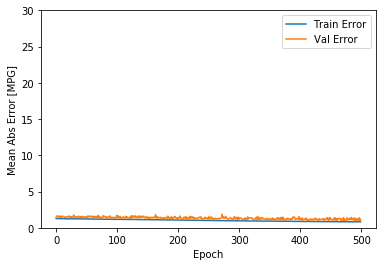

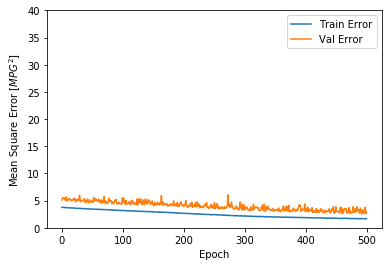

In [12]:
plot_history(history_object_B)

In [13]:
# Range of how wrong we allow a prediction to be, random number for now. unsure what is considered "good"
def accuracy(errorVec, epsilon):
    numExamples = len(errorVec)
    numCorrect = 0
    for error in errorVec:
        if abs(error) <= epsilon:
            numCorrect += 1
    print((numCorrect / float(numExamples))*100,"%")

epsilon = 1
test_predictions_B = model_B.predict(normed_test).flatten()
errorVec = test_predictions_B - test_labels
accuracy(errorVec, epsilon)



53.80658436213992 %
